In [1]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.style.use('ggplot')

In [2]:
CSV_PATHS = 'https://scandeval.com/{language}-nlg.csv'
# CSV_PATHS = str(Path.home() / "gitsky" / "scandeval.com" / "{language}-nlg-test.csv")
CSV_PATHS

'https://scandeval.com/{language}-nlg.csv'

In [3]:
LANGUAGES = ['da', 'no', 'sv', 'de', 'nl', 'en']

In [4]:
models = {
    "gpt-4-0613": "gpt-4",
    "gpt-4-1106-preview": "gpt-4-turbo",
    "gpt-4o-2024-05-13": "gpt-4o",
    "meta-llama/Llama-2-70b-hf": "llama-2-70b",
    "meta-llama/Meta-Llama-3-70B": "llama-3-70b",
}

all_models = list(models.keys())
all_new_models = list(models.values())

results_dict = dict()
for language in LANGUAGES:
    df = (
        pd
        .read_csv(CSV_PATHS.format(language="germanic"))
        .query('merge == False')
        .set_index('model_id')
    )
    df.index = df.index.map(lambda x: re.sub('\(.*\)', '', x).strip())
    scores = df[f'{language}_rank']

    for model in models:
        if model not in scores:
            scores.loc[model] = scores.loc[list(models.keys())[0]]
            
    scores = scores.loc[all_models]
    results_dict[language] = scores.tolist()

df = pd.DataFrame(results_dict, index=all_new_models)
df

,da,no,sv,de,nl,en
gpt-4,1.16,1.17,1.11,1.19,1.15,1.22
gpt-4-turbo,1.20,1.24,1.18,1.33,1.44,1.17
gpt-4o,1.22,1.28,1.18,1.41,1.52,1.37
llama-2-70b,1.63,2.04,1.71,1.64,2.07,1.54
llama-3-70b,1.39,1.37,1.30,1.34,1.30,1.32


In [5]:
gpt4_models = {model_id: model_name for model_id, model_name in models.items() if "gpt-4" in model_name}
gpt4_values = df.loc[list(gpt4_models.values())[0]]
gpt4_values

da    1.16
no    1.17
sv    1.11
de    1.19
nl    1.15
en    1.22
Name: gpt-4, dtype: float64

In [6]:
gpt4_df = df.loc[list(gpt4_models.values())]
gpt4_df = gpt4_df - gpt4_values
gpt4_df["germanic"] = gpt4_df.mean(axis=1)
gpt4_df

,da,no,sv,de,nl,en,germanic
gpt-4,0.00,0.00,0.00,0.00,0.00,0.00,0.000000
gpt-4-turbo,0.04,0.07,0.07,0.14,0.29,-0.05,0.093333
gpt-4o,0.06,0.11,0.07,0.22,0.37,0.15,0.163333


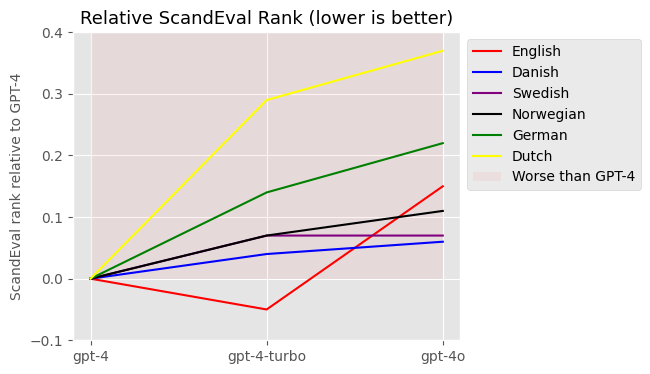

In [10]:
plt.figure(figsize=(5,4))

plt.plot(gpt4_df.en, label="English", color='red')
plt.plot(gpt4_df.da, label="Danish", color='blue')
plt.plot(gpt4_df.sv, label="Swedish", color='purple')
plt.plot(gpt4_df.no, label="Norwegian", color='black')
plt.plot(gpt4_df.de, label="German", color='green')
plt.plot(gpt4_df.nl, label="Dutch", color='yellow')

plt.fill_between(x=gpt4_df.index.tolist(), y1=0.0, y2=0.4, facecolor='red', alpha=0.05, label="Worse than GPT-4")

plt.title("Relative ScandEval Rank (lower is better)", fontsize=13)
plt.ylim(-0.1, 0.4)
plt.ylabel('ScandEval rank relative to GPT-4', fontsize=10)
plt.legend(bbox_to_anchor=(1, 1))

plt.savefig('gpt4-drop.png', bbox_inches="tight", dpi=300)
plt.show()

In [8]:
df["mean"] = df.mean(axis=1)
df

,da,no,sv,de,nl,en,mean
gpt-4,1.16,1.17,1.11,1.19,1.15,1.22,1.166667
gpt-4-turbo,1.20,1.24,1.18,1.33,1.44,1.17,1.260000
gpt-4o,1.22,1.28,1.18,1.41,1.52,1.37,1.330000
llama-2-70b,1.63,2.04,1.71,1.64,2.07,1.54,1.771667
llama-3-70b,1.39,1.37,1.30,1.34,1.30,1.32,1.336667


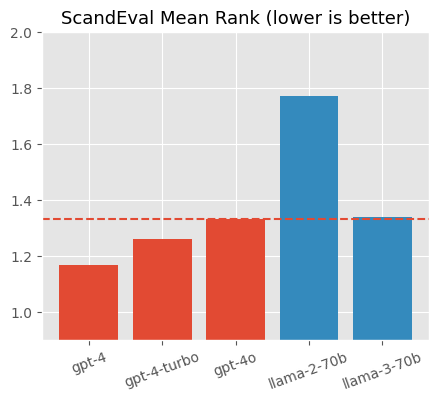

In [9]:
plt.figure(figsize=(5,4))
plt.title('ScandEval Mean Rank (lower is better)', fontsize=13)

gpt4_model_names = [model_name for model_name in models.values() if "gpt-4" in model_name]
plt.bar(x=gpt4_model_names, height=df.loc[gpt4_model_names, "mean"])

llama_model_names = [model_name for model_name in models.values() if "llama" in model_name]
plt.bar(x=llama_model_names, height=df.loc[llama_model_names, "mean"])

plt.axhline(y=df.loc["gpt-4o", "mean"], linestyle="--")

plt.xticks(rotation=20)
plt.ylim(0.9, 2.0)
plt.savefig('gpt4-llama.png', bbox_inches="tight", dpi=300)
plt.show()